# CSE 152A Winter 2024 – Assignment 4

Assignment Published On: **Sat, Mar 2, 2024**

Due On: **Tue, Mar 12, 2024 11:59 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- **Please install following packages in order to run the code: PyTorch, Torchvision, matplotlib, scikit-learn**
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file.

# 1. Backpropogation [10 Points]

We will study the backpropagation behavior for a  [sigmoid neuron](https://en.wikipedia.org/wiki/Sigmoid_function), given by:

$$
f(z) = \frac{1}{1+e^{-z}}
$$

Consider a two-dimensional input given by $x = (x_1, x_2)^T$. A weight vector $w = (w_1, w_2)^T$ and a bias $b$ act on it. Thus, the output of a neuron is given by $f(x_1, x_2) = \frac{1}{1+e^{-(w_1x_1+w_2x_2+b)}}$.
\
\
(a.) Draw the computational graph for the neuron in terms of elementary operations (addition, subtraction, multiplication, division, exponentiation) as seen in class. **[2 points]**

(b.) Consider inputs $x_1 = 0.3, x_2=0.4,$ weights $w_1 = 0.3, w_2 = 0.6$ and bias $b = 0.2$. In the same figure, show the values at each node of the graph during forward propagation. **[2 points]**

(c.) Use backpropagation to determine the gradients $\frac{\partial f}{\partial w_1}, \frac{\partial f}{\partial w_2}, \frac{\partial f}{\partial b}$. Also illustrate in the same figure the intermediate gradients at each node of the computation graph. **[4 points]**

(d.) Explain the process of backpropagation you used to compute partial derivatives. **[2 points]**

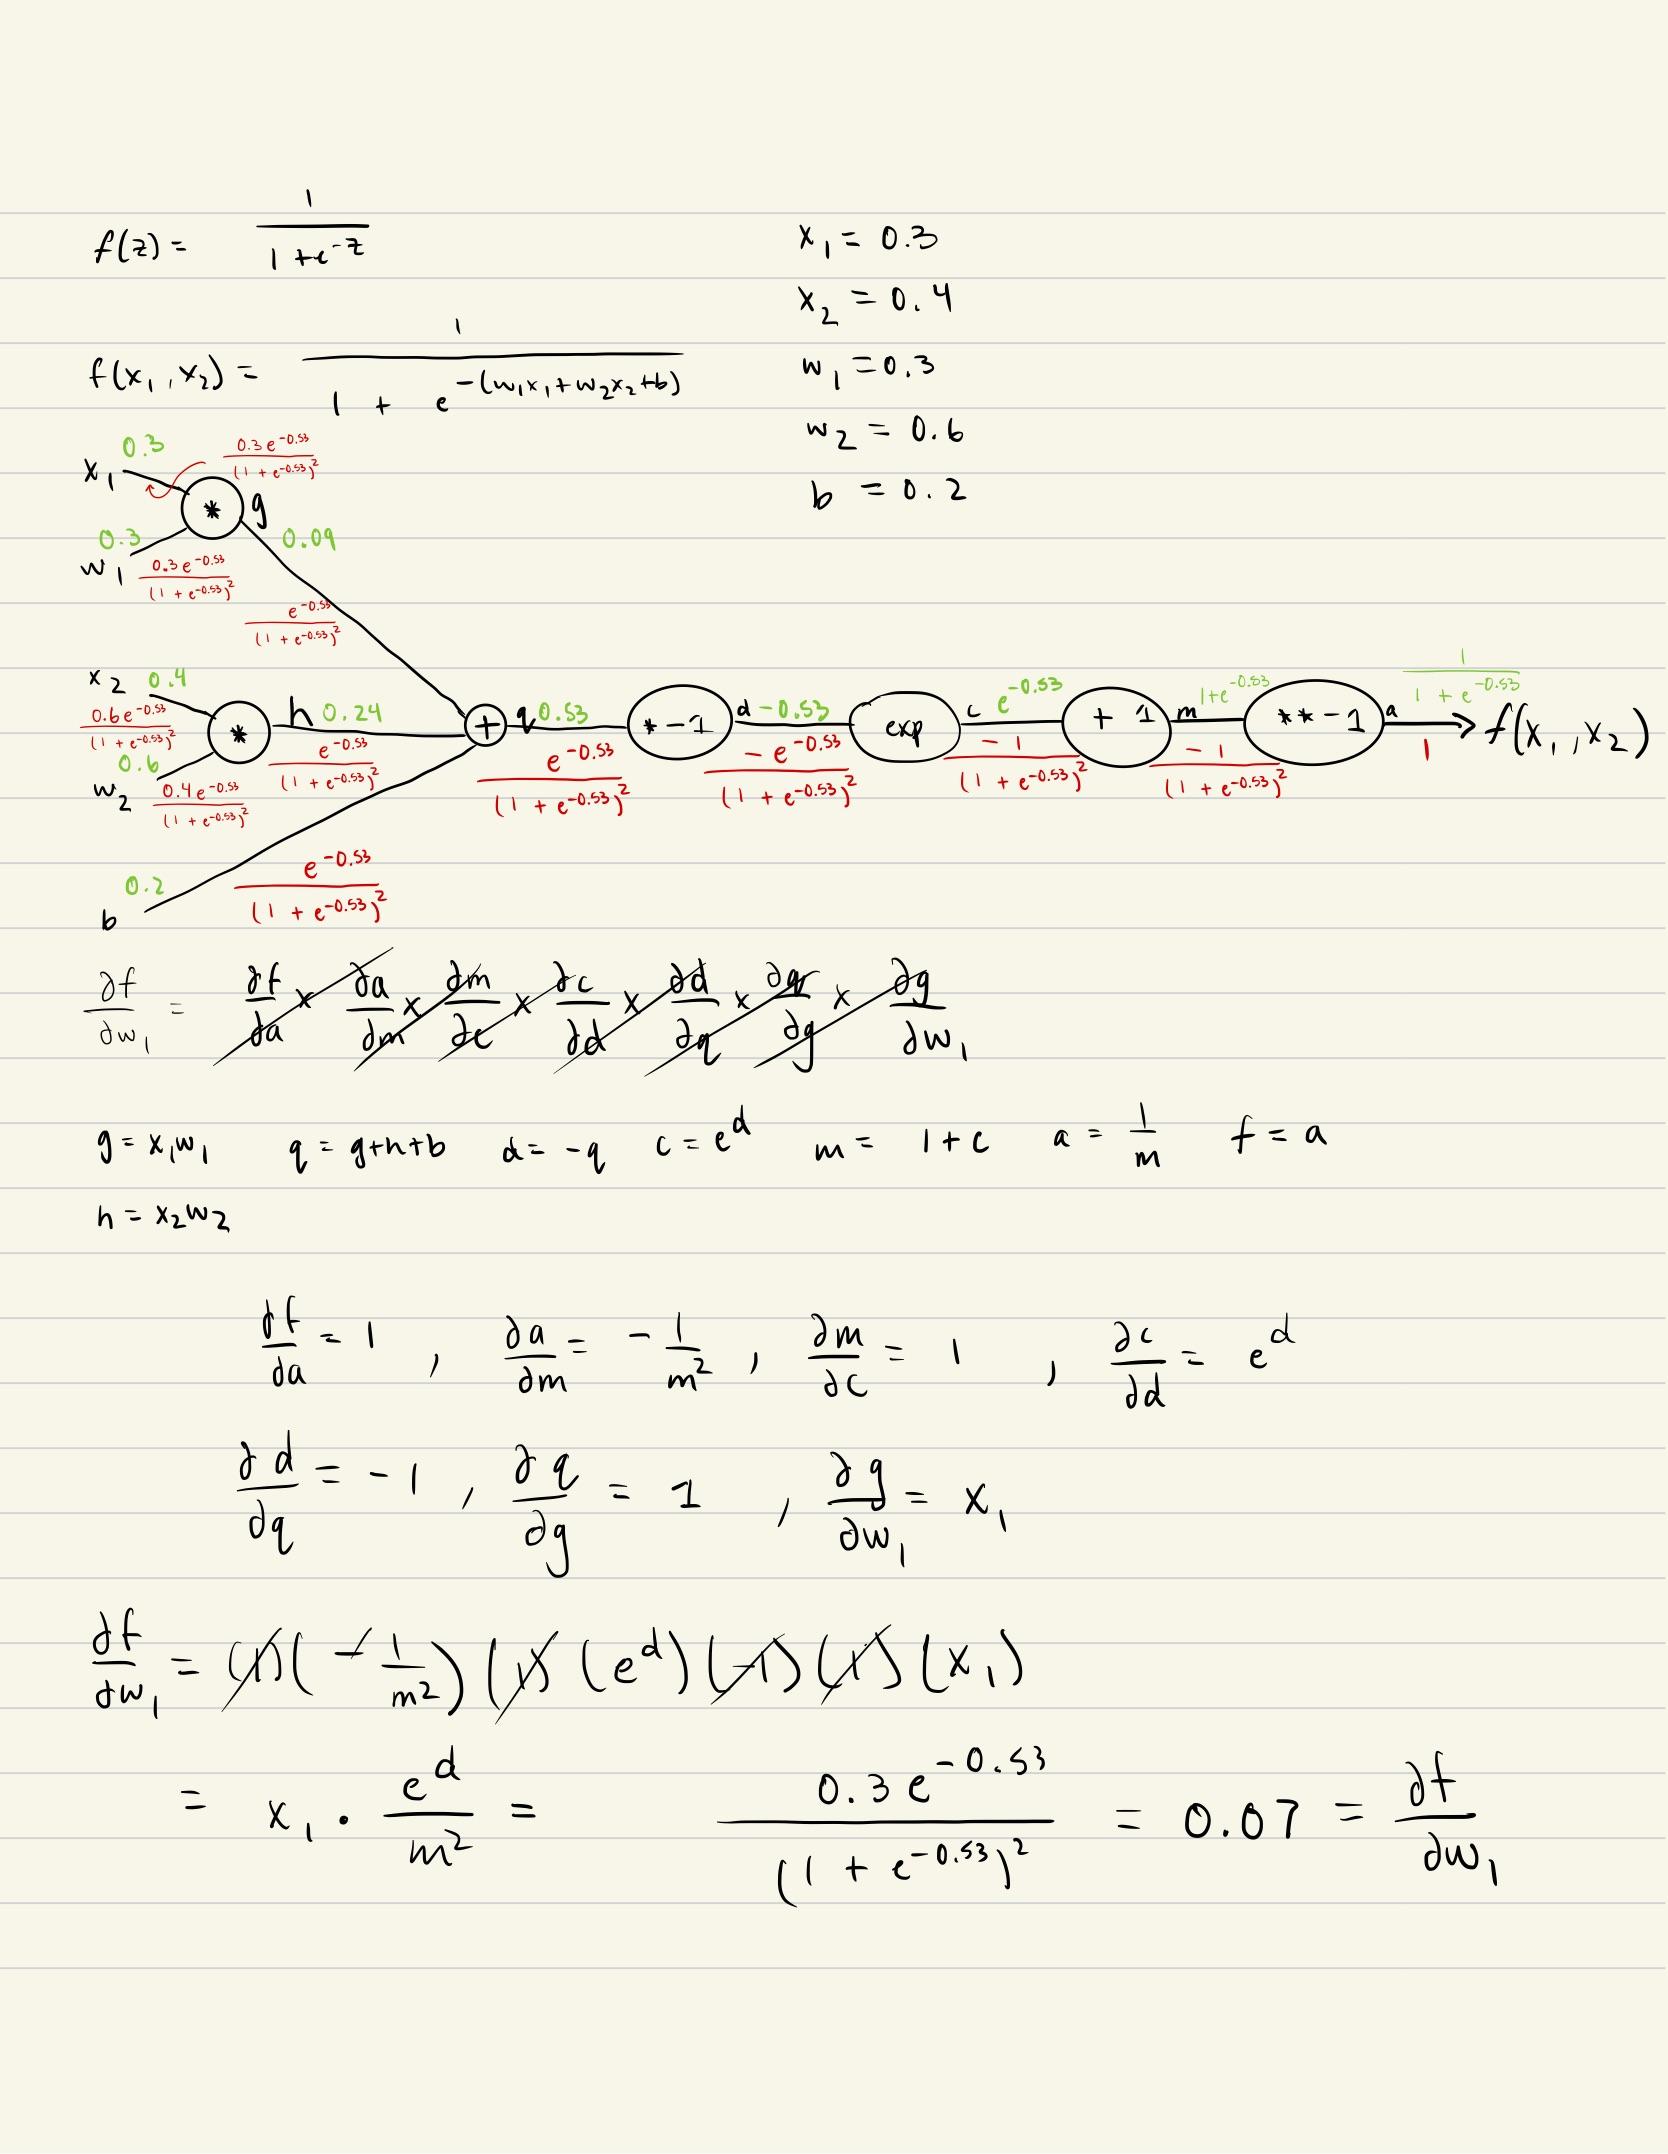

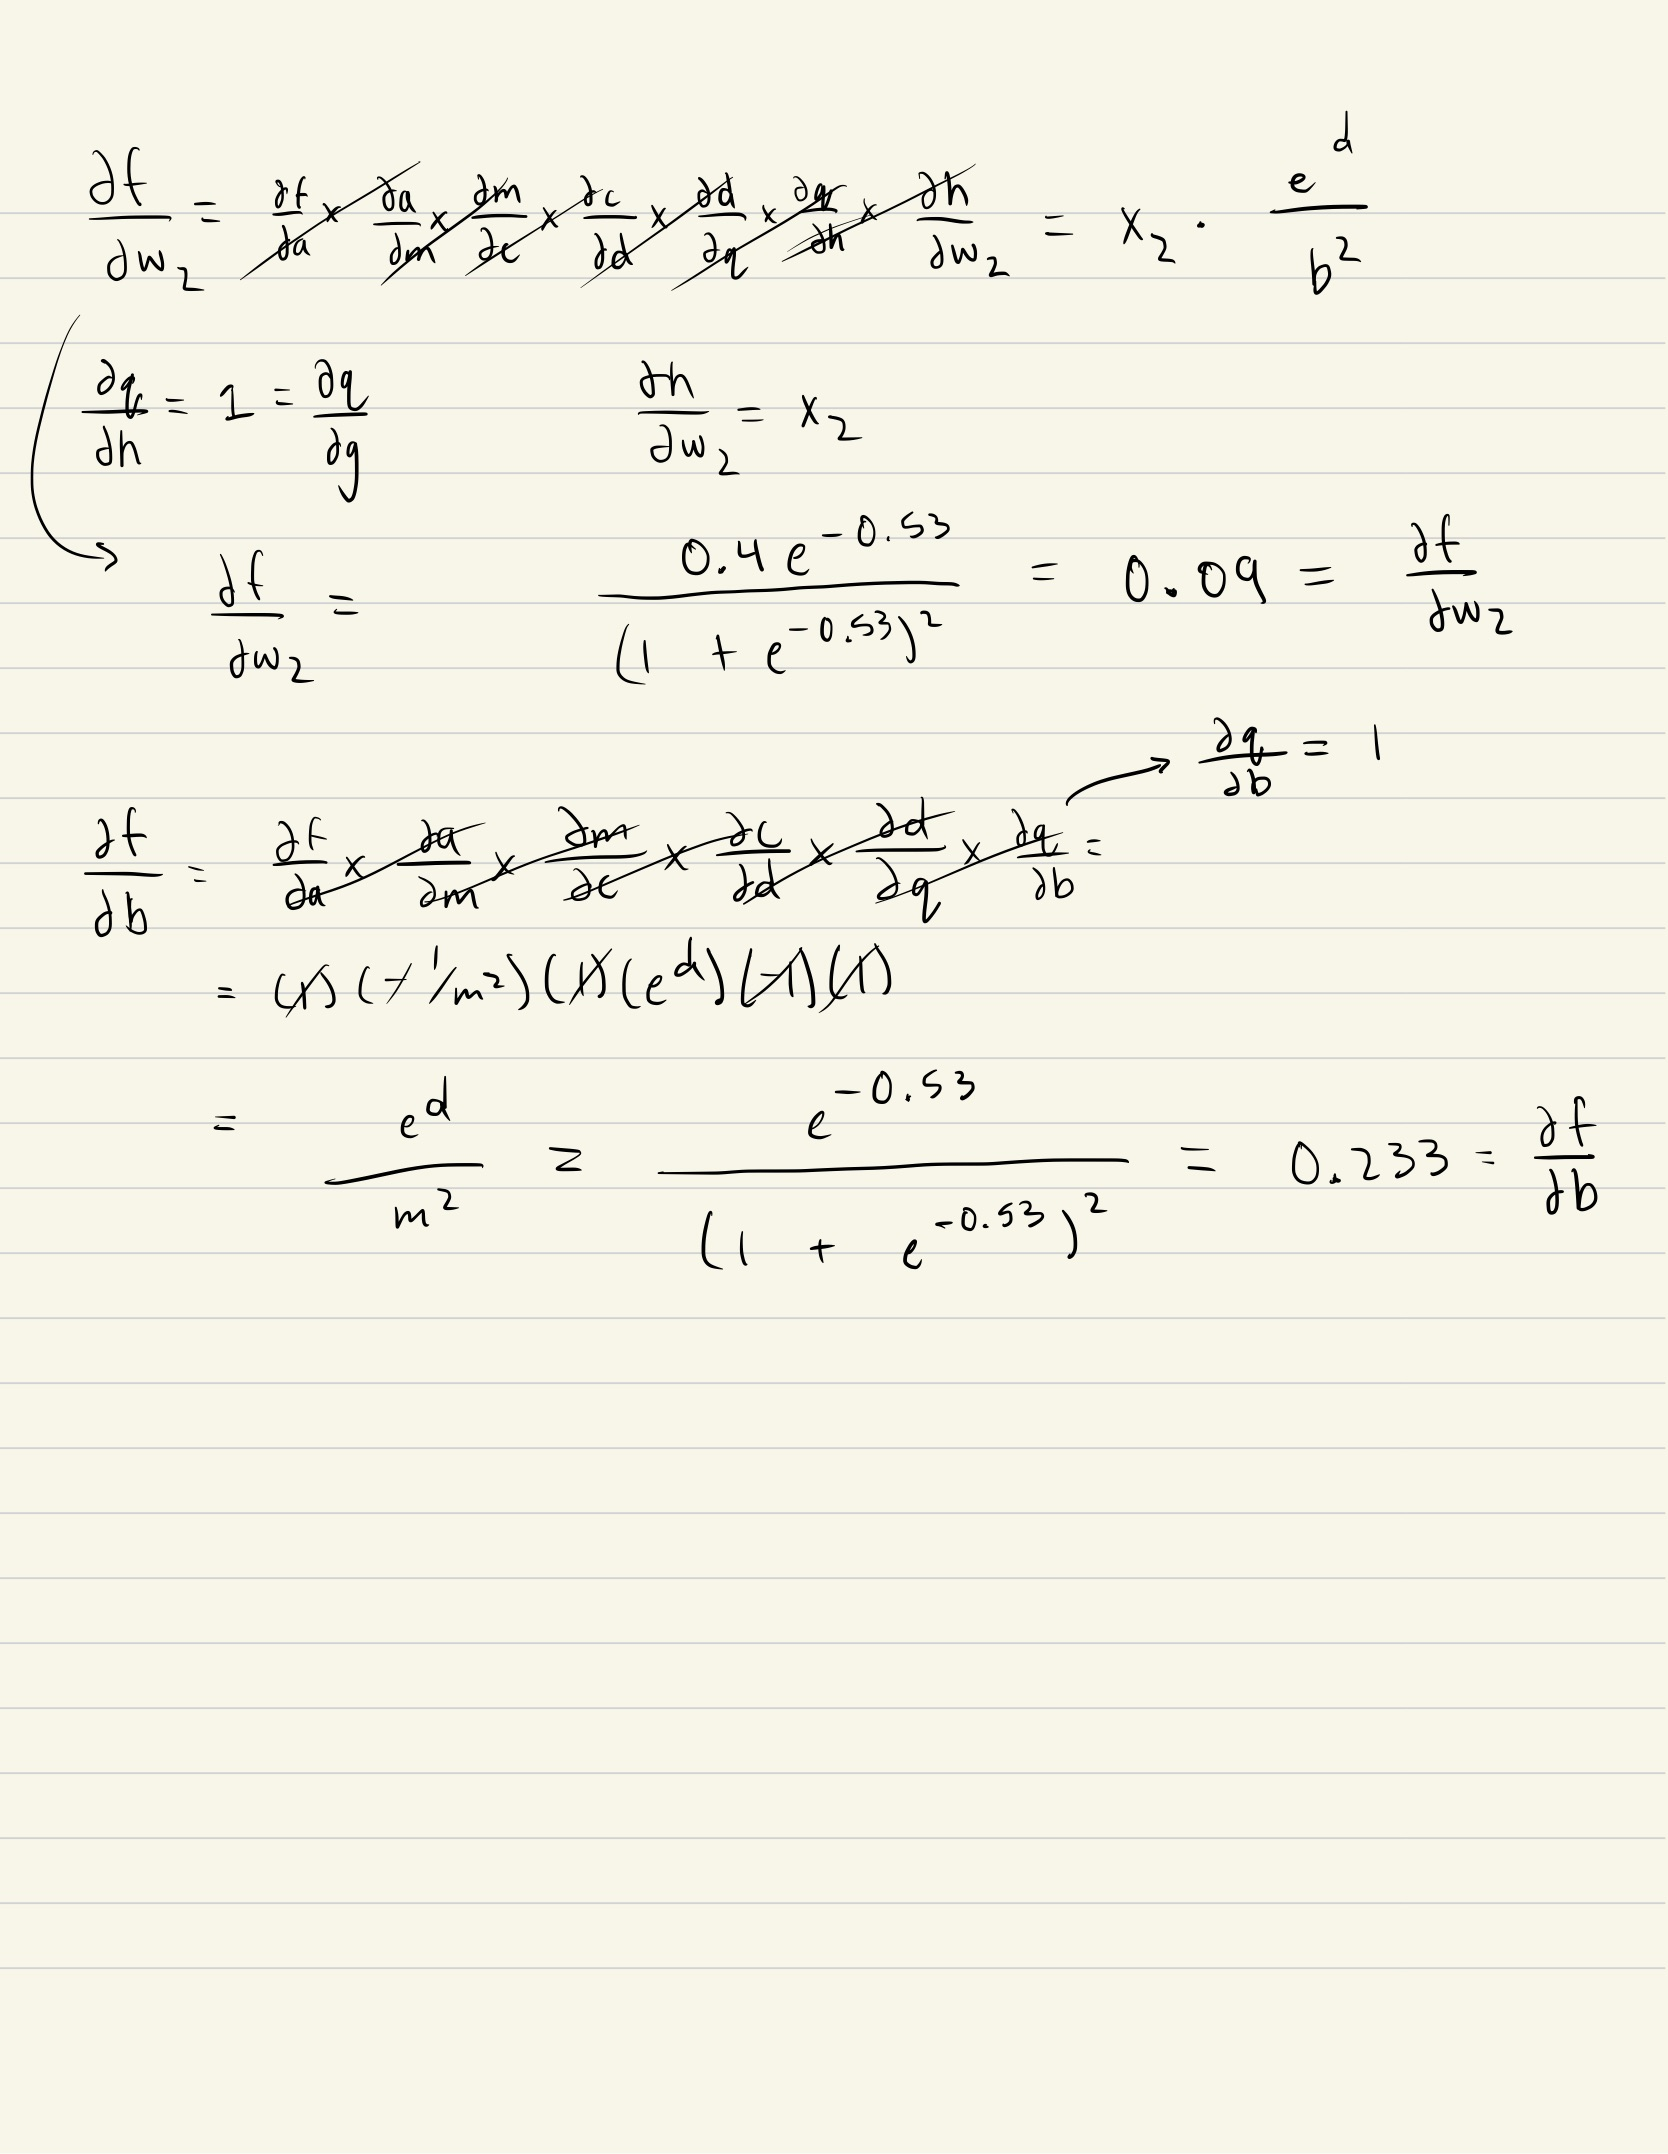

**Ans to (d):** Starting at the function $f(x_{1},x_{2})$, I calculated the gradient of $\frac{\partial f}{\partial a} = 1$, then went to the previous node labeled by $m$ and calculated its gradient $\frac{\partial f}{\partial m}  = \frac{\partial f}{\partial a} \times \frac{\partial a}{\partial m}$. Then I found the gradient of the node labeled by $c$ such that $\frac{\partial f}{\partial c} = \frac{\partial f}{\partial a} \times \frac{\partial a}{\partial m} \times \frac{\partial m}{\partial c}$. I repeated this process of using the Chain Rule for partial derivatives to find $\frac{\partial f}{\partial w_{1}},$ $\frac{\partial f}{\partial w_{2}}$, and $\frac{\partial f}{\partial b}$ as seen in the images above. To find the values of each intermediate partial, I set each node to a function as seen in the images above. For example, $g = x_{1}w_{1}$, $h = x_{2}w_{2}$, $q = g+h+b$, $d = -q$, $c = e^d$, $m = 1+c$, $a = 1/m$, $f = a$. Then, finding the partials using the Chain Rule as previously described, I plugged in the values for the final partial equations to find $\frac{\partial f}{\partial w_{1}},$ $\frac{\partial f}{\partial w_{2}}$, and $\frac{\partial f}{\partial b}$.

# 2. Training a small CNN for MNIST digit classification [15 Points]

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

100%|██████████| 9912422/9912422 [00:00<00:00, 137641483.57it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41541733.14it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38818429.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3519403.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



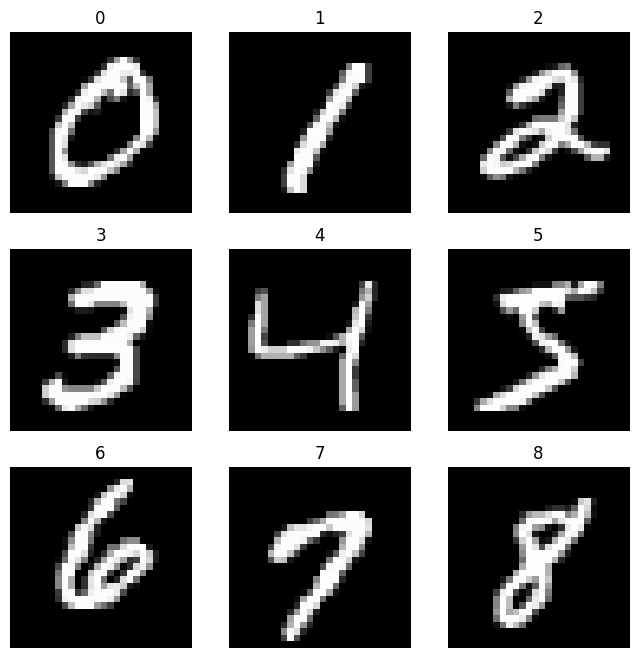

Image Shape: torch.Size([1, 28, 28])


In [23]:
# Load in the datasets

# Download the MNIST Datasets (you will use these variables later on)
MNIST_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

MNIST_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Code adapted from PyTorch https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
train_labels = MNIST_train.targets
label = (train_labels == 0).nonzero()
for i in range(1, cols * rows + 1):
    # Select image of each label
    indices = (train_labels == i-1).nonzero()
    sample_idx = indices[0,0]
    img, label = MNIST_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(i-1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f"Image Shape: {img.shape}")

In [24]:
# Check device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cuda device


**[ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [25]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        self.drop = drop
        # DEFINE THE NETWORK STRUCTURE

        # Example: self.conv1 = nn.Conv2d(1, 3, 5,stride=1,padding=2,bias=True)
        # You can look at the main PyTorch tutorial for reference
        # https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

        # --------------- YOUR CODE HERE ---------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2, bias=True)
        # Hout = Wout = 28 --> then do the max pooling --> Hout = Wout = 14
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2, bias=True)
        # Hout = Wout = 14 --> then do the max pooling --> Hout = Wout = 7
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=1024) # What will the input dimension be?
        self.fc2 = nn.Linear(in_features=1024, out_features=10) # How will dropout work here?

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.4)
        self.flatten = nn.Flatten()

    def forward(self, x):

        # --------------- YOUR CODE HERE ---------------
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return x

# Print net
net = Net(drop=True).to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


**[ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**

* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on training set on the same plot
* Print the accuracy on test set after training

Test accuracies are expected to be quite high (~98 %) for all networks.

Training can take a few minutes.

In [30]:
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# 'to_train' is a parameter that determines what part of the net to train.
# It is not required for this question, but will be useful in the next one.
# You should also change the parameters: epochs, batch, and learning rate as necessary.
# You may need to tune these hyperparameters.
def train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
    # Initialize loss
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]

    # Create dataloader
    MNIST_train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Select optimizer
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
    optimizer.zero_grad()

    # Set model to training mode
    net.train()
    for k in tqdm(range(epochs)):
        for it, (X,y) in enumerate(MNIST_train_dataloader):
            # Send to device
            X, y = X.to(device), y.to(device)

            # Train the model using the optimizer and the batch data.
            # Append the loss and accuracy from each iteration to the losslist and acclist arrays
            # --------------- YOUR CODE HERE ---------------
            optimizer.zero_grad()
            # Then, we can just pass the data through the model (forward)
            pred = net(X)
            # print(pred.shape)

            # and calculate the loss
            loss = criterion(pred, y)

            # Now, we can calculate the gradients through backpropagation
            loss.backward()

            # Take a step along the direction of the gradient (minimize)
            optimizer.step()

            # Logging
            loss, current = loss.item(), (it + 1) * len(X)
            #if it % 100 == 0:
              #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losslist.append(loss)

            # Calculate number of correct predictions in the batch
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()

            # Compute total accuracy
            acc = correct / y.size(0)
            acclist.append(acc)

    return losslist,acclist

# Used to test or evaluate your network. Already written for you.
def test(test_dataset, net):
    batch = 200
    test_dataloader = DataLoader(test_dataset, batch_size=batch)
    size = len(test_dataloader.dataset)

    # Set model to eval mode
    net.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            # Send to device
            X, y = X.to(device), y.to(device)

            # Prediction
            pred = net(X)

            # Calculate number of correct predictions in the batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute total accuracy
    acc = correct / size
    return acc

100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


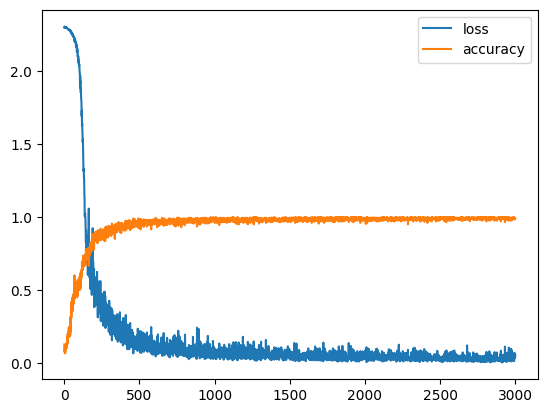

Accuracy:0.9905


In [31]:
# SGD with no dropout
# Example code
net = Net(drop=False).to(device)
loss_sgd_no, acc_sgd_no = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss_sgd_no))
plt.plot(ax, loss_sgd_no, ax, acc_sgd_no)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


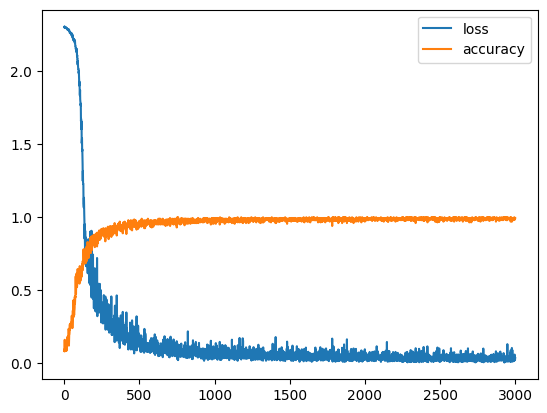

Accuracy:0.9899


In [32]:
# SGD with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss_sgd_drop, acc_sgd_drop = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss_sgd_drop))
plt.plot(ax, loss_sgd_drop, ax, acc_sgd_drop)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [01:34<00:00,  9.43s/it]


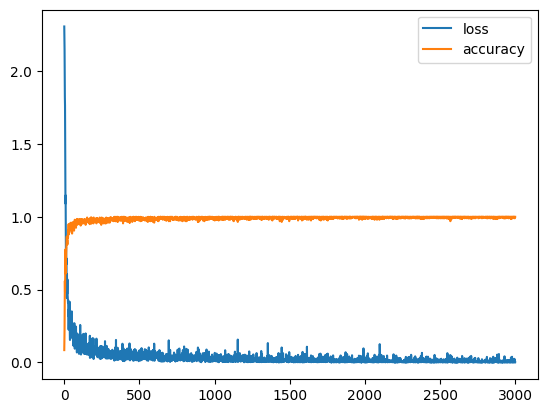

Accuracy:0.9927


In [33]:
# Adam with no dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=False).to(device)
loss_adam_no, acc_adam_no = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss_adam_no))
plt.plot(ax, loss_adam_no, ax, acc_adam_no)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [01:34<00:00,  9.44s/it]


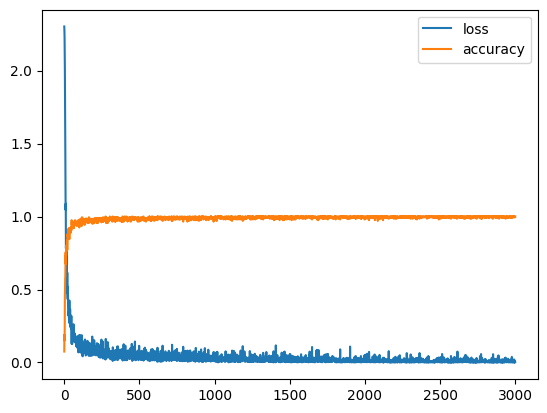

Accuracy:0.9933


In [34]:
# Adam with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss_adam_drop, acc_adam_drop = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss_adam_drop))
plt.plot(ax, loss_adam_drop, ax, acc_adam_drop)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

**[ 5 points ] Plot the following graphs and note your observations**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot.
* Training loss graphs for Adam-dropout for 3 different values of batch sizes of 10, 200 and 500, on the same plot.

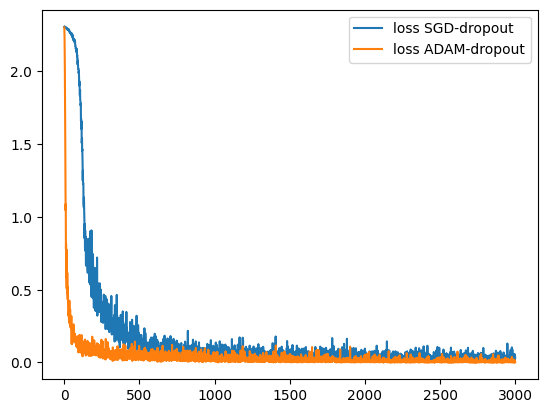

In [35]:
# --------------- YOUR CODE HERE ---------------
# Training loss graphs of SGD-dropout and Adam-dropout on the same plot
# loss_sgd_drop
# loss_adam_drop
ax=range(len(loss_sgd_drop))
plt.plot(ax, loss_sgd_drop, ax, loss_adam_drop)
plt.legend(['loss SGD-dropout', 'loss ADAM-dropout'])
plt.show()

**Observation for SGD-dropout vs ADAM-dropout**: From the plots above, it is seen that ADAM with dropout performs better than SGD with dropout in terms of speed. In other words, ADAM with dropout minimizes the loss (aka converges) faster than SGD with dropout, requiring fewer iterations to converge than SGD. This may be because of ADAM's algorithm that dynamically computes individual learning rates based on past gradients.

100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


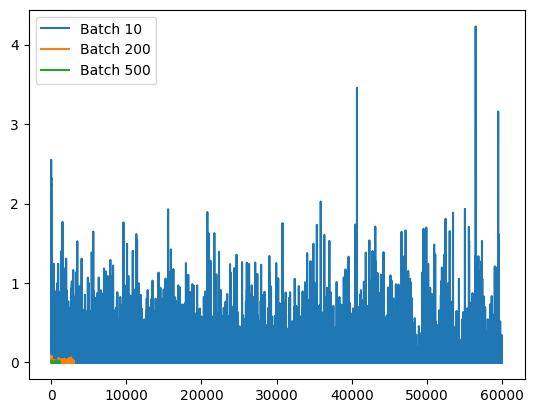

In [9]:
# train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
# Training loss graphs for Adam-dropout for 3 different values
# of batch sizes of 10, 200 and 500, on the same plot.
# loss_sgd_drop
# loss_adam_drop
net = Net(drop=True).to(device)
loss_adam_drop_batch10, acc_adam_drop_batch10 = train(MNIST_train, net,
                                                      net.parameters(), 'adam', batch=10)
loss_adam_drop_batch200, acc_adam_drop_batch200 = train(MNIST_train, net,
                                                        net.parameters(), 'adam', batch=200)
loss_adam_drop_batch500, acc_adam_drop_batch500 = train(MNIST_train, net,
                                                        net.parameters(), 'adam', batch=500)
ax1=range(len(loss_adam_drop_batch10))
ax2=range(len(loss_adam_drop_batch200))
ax3=range(len(loss_adam_drop_batch500))
plt.plot(ax1, loss_adam_drop_batch10, ax2, loss_adam_drop_batch200, ax3, loss_adam_drop_batch500)
plt.legend(['Batch 10', 'Batch 200', 'Batch 500'])
plt.show()

**Observation for ADAM with dropout for different batch sizes**: It seems that the larger the batch size, the better performance in terms of converging and minimizing the loss function. Batch size of 200 minimizes loss faster than batch size of 10 whereas batch size of 500 minimizes loss faster than batch size 10 and batch size 200.

**[ 2 points ] The learning rate is a key hyperparameter during training. For this question, do the following.**

1. [ 1 point ] Train three models for three different values of the learning rate hyperparameter. Plot the loss graphs for training with these values of the learning rate on the same plot. Make sure that you change the hyperparameter enough such that there is a clear difference in the graphs and comment on the differences. Use SGD optimizer and no dropout.

2. [ 1 point ] Repeat the above task, but this time, use dropout with SGD optimizer. Note down your observations.

100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


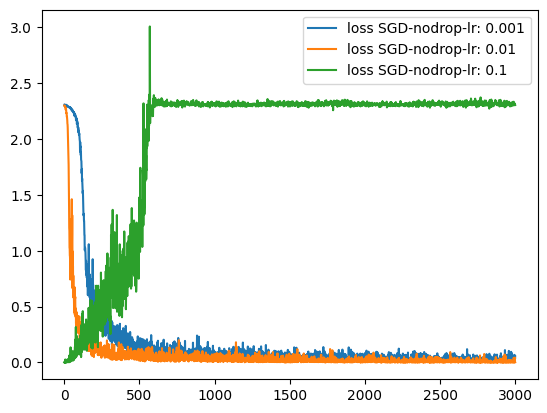

In [36]:
# --------------- YOUR CODE HERE ---------------
# --------------- SGD No Dropout ---------------
# train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
net = Net(drop=False).to(device)
# default model with learning rate of 0.001
loss_sgd_no_drop1 = loss_sgd_no
# Learning rate of 0.01
loss_sgd_no_drop2, acc_sgd_no_drop2 = train(MNIST_train, net,
                                            net.parameters(), 'sgd', learning_rate=1e-2)
# Learning rate of 0.1
loss_sgd_no_drop3, acc_sgd_no_drop3 = train(MNIST_train, net,
                                            net.parameters(), 'sgd', learning_rate=1e-1)
ax1=range(len(loss_sgd_no_drop1))
ax2=range(len(loss_sgd_no_drop2))
ax3=range(len(loss_sgd_no_drop3))
plt.plot(ax1, loss_sgd_no_drop1, ax2, loss_sgd_no_drop2, ax3, loss_sgd_no_drop3)
plt.legend(['loss SGD-nodrop-lr: 0.001', 'loss SGD-nodrop-lr: 0.01', 'loss SGD-nodrop-lr: 0.1'])
plt.show()

**Observation of SGD-no dropout varying learning rates**: From the above plots, it is not always the case that the best learning rate is always the largest value nor the smallest value. From the above plots, with a learning rate of 0.001, the loss function converges slower than the loss with a learning rate of 0.01. The loss function with a learning rate of 0.1 diverges, implying that the loss function is not being minimized, and the overall CNN model is not functioning as required as it is computing and overshooting the gradients too aggressivley. As a result, the best learning rate for SGD without dropout is one that causes the loss function to rapidly converge at a minimum which may usually be between larger and smaller values of learning rates (i.e. somewhere in between). This is to ensure speed and accuracy of the model.

100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


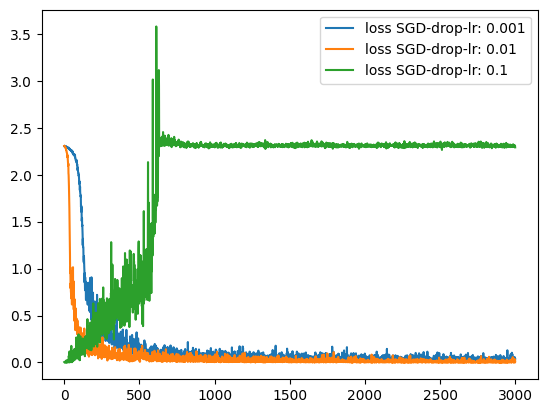

In [37]:
# --------------- YOUR CODE HERE ---------------
# -------------- SGD with Dropout --------------
# train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
net = Net(drop=True).to(device)
# default model with learning rate of 0.001
loss_sgd_drop1 = loss_sgd_drop
# Learning rate of 0.01
loss_sgd_drop2, acc_sgd_drop2 = train(MNIST_train, net,
                                      net.parameters(), 'sgd', learning_rate=1e-2)
# Learning rate of 0.1
loss_sgd_drop3, acc_sgd_drop3 = train(MNIST_train, net,
                                      net.parameters(), 'sgd', learning_rate=1e-1)
ax=range(len(loss_sgd_drop1))
plt.plot(ax, loss_sgd_drop1, ax, loss_sgd_drop2, ax, loss_sgd_drop3)
plt.legend(['loss SGD-drop-lr: 0.001', 'loss SGD-drop-lr: 0.01', 'loss SGD-drop-lr: 0.1'])
plt.show()

**Observation of SGD-dropout varying learning rates**: The above plots support the same observations made from varying the learning rates on the SGD model without dropout such that the best learning rate for minimizing loss as fast and efficient as possible is somewhere in between larger and smaller values. The slight difference is that in SGD-dropout, the models of learning rates 0.01 and 0.001 converge slightly faster than those of SGD-no dropuot for the same learning rates. The SGD-droput with learning rate of 0.1 also diverges slower than the SGD-no droput with learning rate of 0.01.

# 3. Transfer learning [15 Points]

You will now visualize the effects of transfer learning by performing experiments using the SVHN dataset (http://ufldl.stanford.edu/housenumbers/) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks.

In [38]:
!mkdir SVHN
%cd SVHN
!wget -nc http://ufldl.stanford.edu/housenumbers/train_32x32.mat
%cd ..

# Convert .mat files to np arrays
import scipy.io as sio
import numpy as np

def load_data(path):
    data = sio.loadmat(path)
    return np.array(data['X']), np.array(data['y'])

data, labels = load_data('SVHN/train_32x32.mat')
data = data.transpose((3, 2, 0, 1))
print(data.shape)
labels  = labels.reshape(-1)
print(labels.shape)

mkdir: cannot create directory ‘SVHN’: File exists
/content/SVHN
File ‘train_32x32.mat’ already there; not retrieving.

/content
(73257, 3, 32, 32)
(73257,)


 **[ 2 points ] Plot 3 random images corresponding to each label from the training data**


In [39]:
unique_labels = torch.unique(torch.tensor(labels))
print(unique_labels)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.uint8)


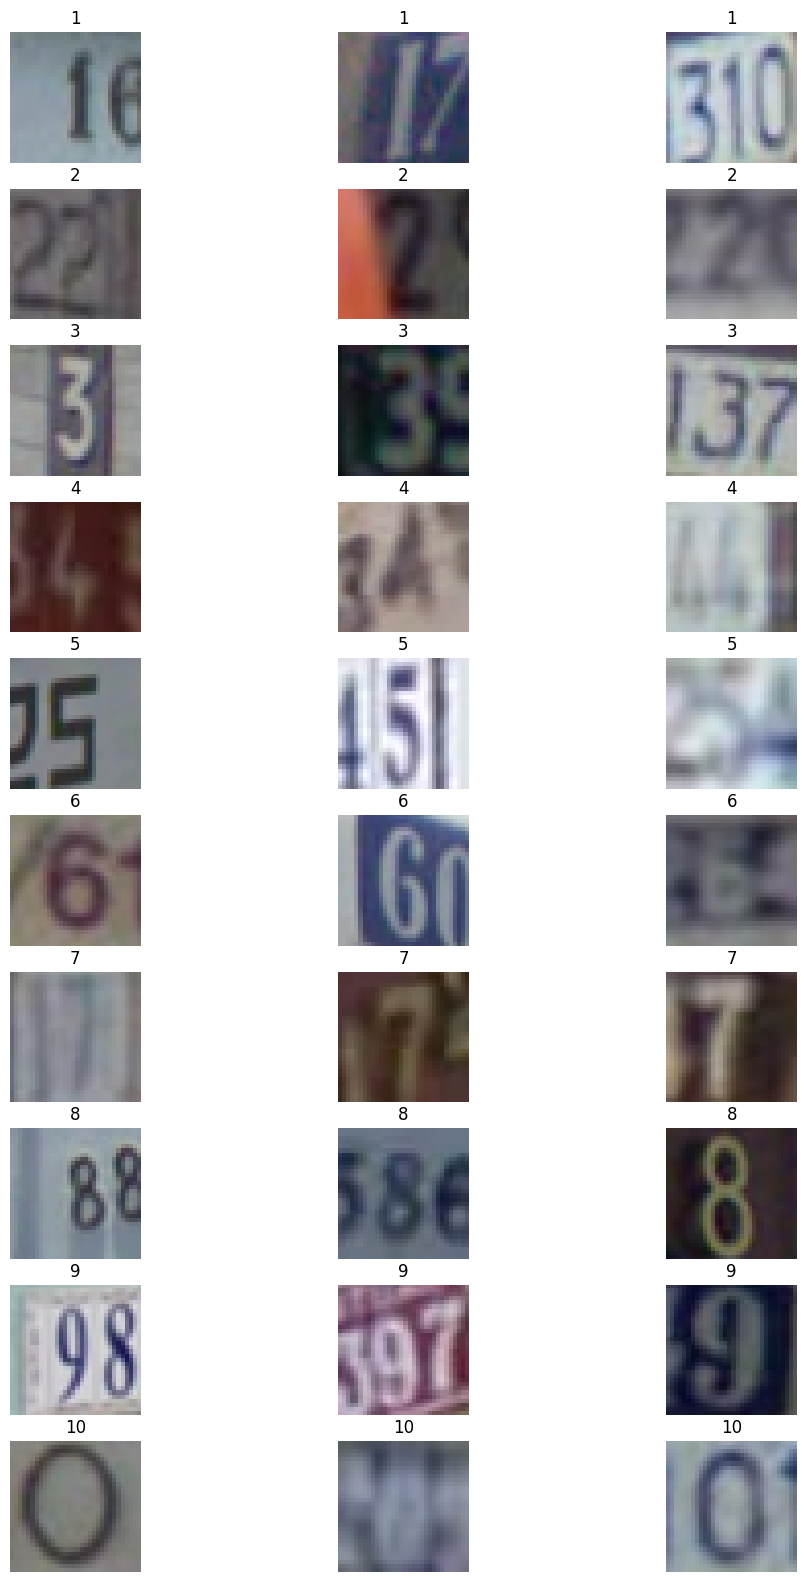

In [40]:
# --------------- YOUR CODE HERE ---------------
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 20))
axes = axes.flatten()
# Iterate through the set of labels
# Randomly select 3 images that contain the current label
# Plot these images with their labels
count = 0
for l in unique_labels:
  for i in range(3):
    # Get the random image and plot it
    while(True):
      random_index = np.random.randint(0, len(labels))
      if(labels[random_index] == l):
        random_image = data[random_index]
        axes[count].set_title(l.item())
        axes[count].imshow(random_image.transpose(1, 2, 0))
        # axes[count].set_aspect('auto')
        axes[count].axis('off')
        count += 1
        break
plt.show()

We will split the dataset into two parts, one with labels 0-4 and other with labels 5-9, we have provided this code for you. This should print the sizes of data and labels in each split.

In [43]:
# Split the data and labels into two sets corresponding to labels 0-4 and 5-9.
data1 = np.zeros((0, 3, 32, 32))
labels1 = []
data2 = np.zeros((0, 3, 32, 32))
labels2 = []

## SVHN has labels in the range 1-10 and not 0-9.
# Split data and labels for labels 0 to 4
for i in range(5):
    x = data[labels == i+1][:5000]
    data1 = np.vstack((data1, x))
    labels1 += [i] * len(x)

# Split data and labels for labels 5 to 9
for i in range(5, 10):
    x = data[labels == i+1][:5000]
    data2 = np.vstack((data2, x))
    labels2 += [i] * len(x)

## Neural networks always accept labels in the range 0 to n-1.
## change data from cardinal to ordinal.
labels1 = np.array(labels1)
labels2 = np.array(labels2) - 5

data1.shape, data2.shape, labels1.shape, labels2.shape

## should print ((25000, 3, 32, 32), (24607, 3, 32, 32), (25000,), (24607,))

((25000, 3, 32, 32), (24607, 3, 32, 32), (25000,), (24607,))

**[ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**

1. Layer 1 - Convolutional layer with kernel size 4, Stride 2, Output channels 5, Relu activation
2. Layer 2 - Convolutional layer with kernel size 4, Stride 1, Output channels 10, Relu avtication
3. Layer 3 - Convolutional layer with kernel size 4, Stride 1, Output channels 20, Relu activation
4. Layer 4 - Convolutional layer with kernel size 4, Stride 1, Output channels 40, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [44]:
class Net(nn.Module):
    def __init__(self, n_labels=5):
        super().__init__()
        # --------------- YOUR CODE HERE ---------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4, stride=2)
        # Hout = Wout = 15
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=4, stride=1)
        # Hout = Wout = 12
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
        # Hout = Wout = 9
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=4, stride=1)
        # Hout = Wout = 6
        self.fc1 = nn.Linear(in_features=40*6*6, out_features=5)

        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # --------------- YOUR CODE HERE ---------------
        # Layer 1
        x = self.relu(self.conv1(x))
        # Layer 2
        x = self.relu(self.conv2(x))
        # Layer 3
        x = self.relu(self.conv3(x))
        # Layer 4
        x = self.relu(self.conv4(x))
        # Layer 5
        x = self.fc1(self.flatten(x))
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1440, out_features=5, bias=True)
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


**[ 5 points ] Complete the train function below and follow the instructions**

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 55 %.

In [125]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist = [] # Hint: use argmax to find the index with the largest value

    # YOU MAY NEED TO CHANGE THESE PARAMETERS TO IMPROVE ACCURACY
    epochs=20
    batch=64
    learning_rate=3e-3
    optimizer = optim.SGD(to_train,lr=learning_rate)
    optimizer.zero_grad()

    for k in tqdm(range(epochs)):
        ## Shuffle the data
        indices = np.arange(len(tdata))
        np.random.shuffle(indices)
        tdata = tdata[indices]
        tlabel = tlabel[indices]

        for l in range(int(len(tdata)/batch)):

            inputs = torch.FloatTensor(tdata[l*batch:(l+1)*batch]).to(device)
            targets = torch.LongTensor(tlabel[l*batch:(l+1)*batch]).to(device)
            # --------------- YOUR CODE HERE ---------------
            # Calculate the loss and the accuracy
            # Input loss and accuracy in their own lists

            optimizer.zero_grad()

            pred = net(inputs)

            loss = criterion(pred, targets)

            loss.backward()

            optimizer.step()

            # Logging
            loss, current = loss.item(), (batch + 1) * len(inputs)
            #if batch % 100 == 0:
              #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losslist.append(loss)

            # Calculate number of correct predictions in the batch
            correct = (pred.argmax(1) == targets).type(torch.float).sum().item()
            # Compute total accuracy
            acc = correct / targets.size(0)
            acclist.append(acc)


    return losslist,acclist

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


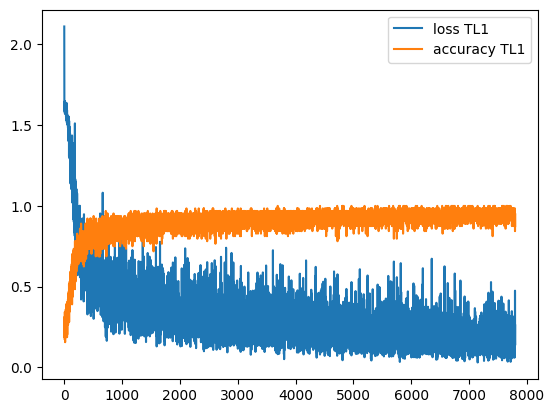

Final Training Accuracy on data1: 0.875


In [126]:
# --------------- YOUR CODE HERE ---------------
# Training loss and accuracy on data1 without Transfer Learning
# Initialize the network, train the complete
# network (net.parameters) on data1 (The first 5 classes)
# Plot the loss and accuracy graphs over training on the same plot
# Print the final training accuracy as well**
# Example code
net_tl1 = Net().to(device)
loss_tl1, acc_tl1 = train(data1,labels1,net_tl1,net_tl1.parameters())
ax=range(len(loss_tl1))
plt.plot(ax, loss_tl1, ax, acc_tl1)
plt.legend(['loss TL1', 'accuracy TL1'])
plt.show()
print('Final Training Accuracy on data1:', acc_tl1[-1])


**[ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)**

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


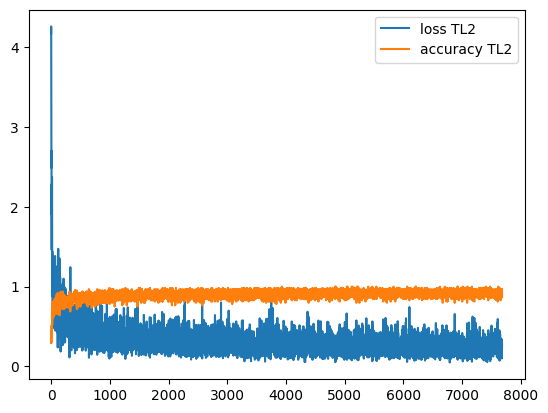

Final Training Accuracy on data2 with Transfer Learning: 0.875


In [127]:
# --------------- YOUR CODE HERE ---------------
# Training loss and accuracy on data2 with Transfer Learning
loss_tl2, acc_tl2 = train(data2,labels2,net_tl1,net_tl1.fc1.parameters())
ax=range(len(loss_tl2))
plt.plot(ax, loss_tl2, ax, acc_tl2)
plt.legend(['loss TL2', 'accuracy TL2'])
plt.show()
print('Final Training Accuracy on data2 with Transfer Learning:', acc_tl2[-1])

**[ 3 points ] Now repeat the process in the opposite order**

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


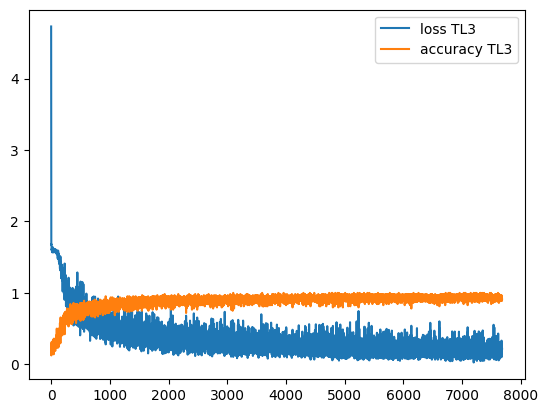

Final Training Accuracy on data2: 0.90625


In [132]:
# --------------- YOUR CODE HERE ---------------
# Training loss and accuracy on data2 without Transfer Learning
net_tl2 = Net().to(device)
loss_tl3, acc_tl3 = train(data2,labels2,net_tl2,net_tl2.parameters())
ax=range(len(loss_tl3))
plt.plot(ax, loss_tl3, ax, acc_tl3)
plt.legend(['loss TL3', 'accuracy TL3'])
plt.show()
print('Final Training Accuracy on data2:', acc_tl3[-1])

100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


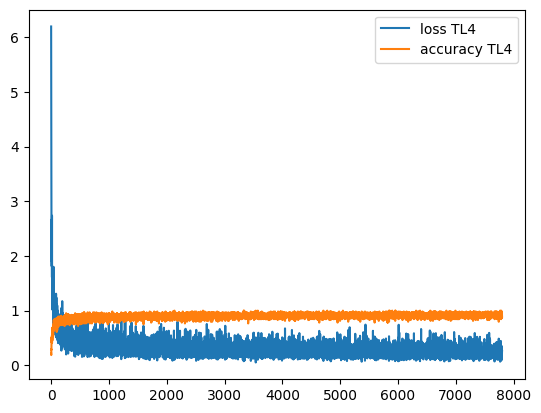

Final Training Accuracy on data1 with Transfer Learning: 0.890625


In [133]:
# Training loss and accuracy on data1 with Transfer Learning
loss_tl4, acc_tl4 = train(data1,labels1,net_tl2,net_tl2.fc1.parameters())
ax=range(len(loss_tl4))
plt.plot(ax, loss_tl4, ax, acc_tl4)
plt.legend(['loss TL4', 'accuracy TL4'])
plt.show()
print('Final Training Accuracy on data1 with Transfer Learning:', acc_tl4[-1])

**[ 5 points ]**

* Plot the accuracy vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

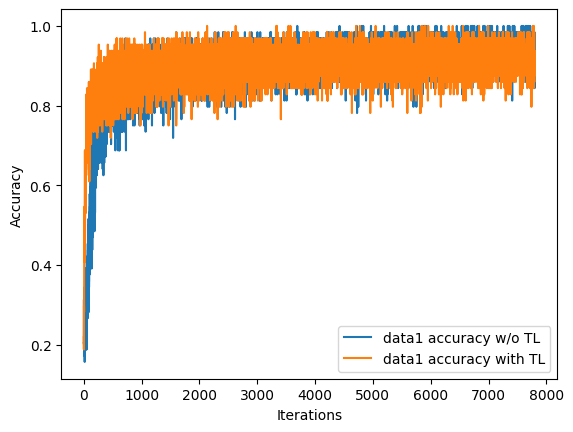

In [134]:
# --------------- YOUR CODE HERE ---------------
# Plot for data1 normal learning vs transfer learning
ax=range(len(acc_tl1))
plt.plot(ax, acc_tl1, ax, acc_tl4)
plt.legend(['data1 accuracy w/o TL', 'data1 accuracy with TL'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

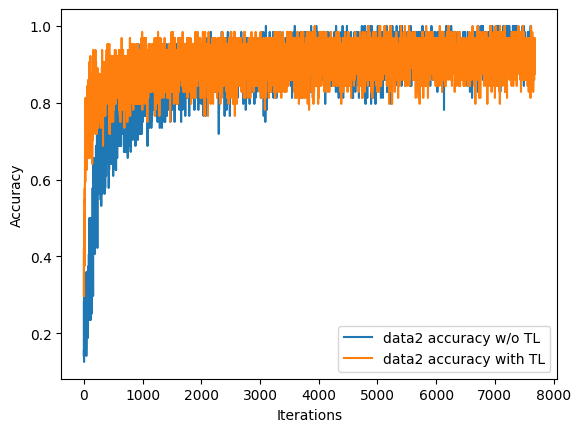

In [135]:
# Plot for data2 normal learning vs transfer learning
ax=range(len(acc_tl3))
plt.plot(ax, acc_tl3, ax, acc_tl2)
plt.legend(['data2 accuracy w/o TL', 'data2 accuracy with TL'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

**Explanation**: From the above plots, it seems that Transfer Learning worked for both training regimens for data1 and data2 training sets. The above images both show that the accuracy with transfer learning converges around average 90%, faster than the models without Transfer Learning. This may be because we assume that we found the best hyperparameters in the full network that minimizes loss and maximizes accuracy, which we then transfer over to the next model as the most optimal starting point to train the fully connected layers based on the new unseen datasets.

**Optional**: Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this.